# Temperature Anomaly Forecasting with SARIMA

In this jupyter notebook, we will build the SARIMA model by choosing the parameters manually instead of using Auto ARIMA. The Auro Arima gave us very poor forecasts in the previous section. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#First, let's import out dataset

# Load the dataset

from utils import load_caribbean_weather

df = load_caribbean_weather()

In [4]:
df_t = df[['temp_anomaly']]
df_t.describe()

,temp_anomaly
count,550.000000
mean,0.471727
std,0.332367
min,-0.120000
25%,0.230000
50%,0.410000
75%,0.697500
max,1.500000


## Autocorrelation Function
measures correlation between the temperature series and its past values (lags).

<Figure size 1200x600 with 0 Axes>

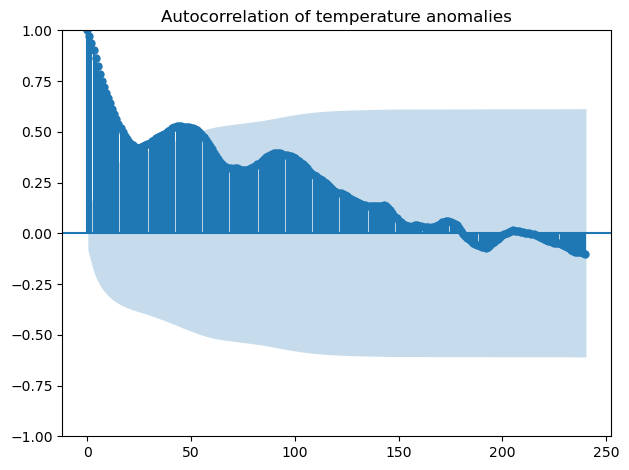

In [14]:
plt.figure(figsize=(12,6))
plot_acf(df_t, lags=240, title='Autocorrelation of temperature anomalies')
plt.tight_layout()
plt.show()

Key Observations:

*High correlation at lags 1 and 2*, the first 2 lags have strong positive correlations, indicating that this month's temperature is roughly influenced by temperature of the last two months. 
*Periodic Spikes*, notice the regular spikes at approximately 48 months, suggesting 4-year seasonality. This periodic behavior confirms that temperature patterns repeates every 4 years.
*Gradual Decay*, the autocorrelation gradually decreases as the lag features increase, indicating that the relationship between present and past weakens over time. This suggests a combination of *trend and seasonality* in the data.
Most lags within the 48 month period are significant (outside the shaded confidence interval), reinforcing the presence of structured 4-year seasonality.

## Partial Autocorrelation Function
measures correlation between the series and its lagged values.

<Figure size 1200x600 with 0 Axes>

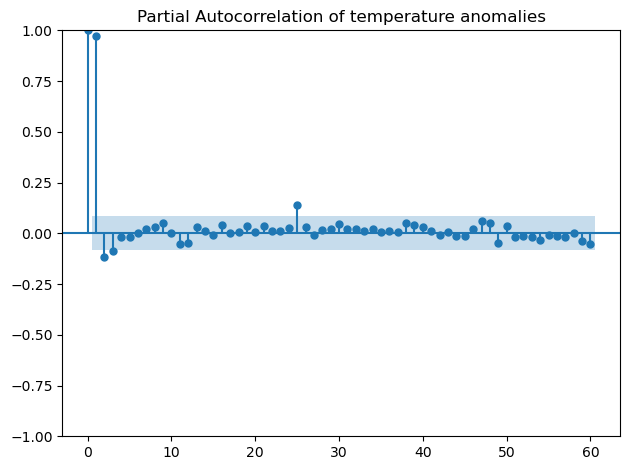

In [19]:
plt.figure(figsize=(12,6))
plot_pacf(df_t, lags=60, title='Partial Autocorrelation of temperature anomalies')
plt.tight_layout()
plt.show()

Key Observations:

*Significant Lags 1 and 2*, the first 2 lags are significant, indicating a strong direct relationship between this month's temperature anomaly and those of two previous months. There is a significant drop-off after lag=2, indicating that the influence of past weather is limited to immediate 2 months. 

## Decomposition and Stationary Plots

The model type is determined to be *additive* based on the nature of seasonal fluctuations. From the ACF/PACF analysis, periodic spikes at 48 months indicate 4-year long seasonality. Thus, a period of 48 is used for decomposition.

In [24]:
df_t.head()

,temp_anomaly
date,
1980-01-01,0.29
1980-02-01,0.31
1980-03-01,0.28
1980-04-01,0.29
1980-05-01,0.35


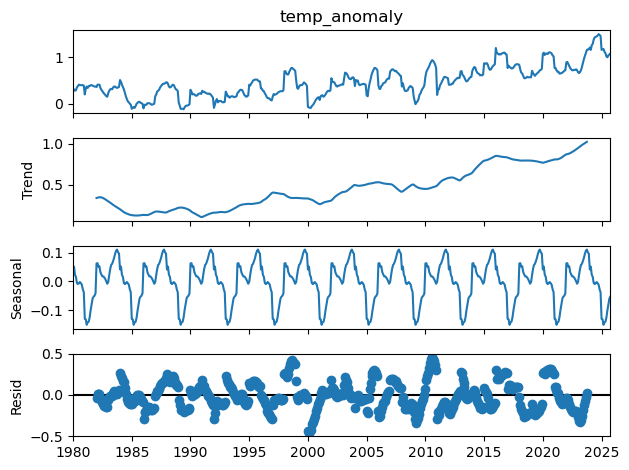

In [4]:
decomposition_4_year = seasonal_decompose(df_t['temp_anomaly'], period=48, model='additive')
decomposition_4_year.plot()
plt.show()

## Check for Stationarity: Augmented Dickey-Fuller (ADF) test

While ACF plot suggests non-stationarity, if we want to confirm it formaly, we need to use the Augmented Dickey-Fuller (ADF) test. 

In [5]:
result = adfuller(df_t['temp_anomaly'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -2.9881276394468608
p-value: 0.036018103077230156
Critical Value (1%): -3.4423614311926514
Critical Value (5%): -2.866838307535097
Critical Value (10%): -2.56959181953083


In [6]:
from statsmodels.tsa.stattools import kpss
print("Results of KPSS Test:")
kpsstest = kpss(df_t['temp_anomaly'], regression="c", nlags="auto")
kpss_output = pd.Series(
    kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
)
for key, value in kpsstest[3].items():
    kpss_output["Critical Value (%s)" % key] = value
print(kpss_output)

Results of KPSS Test:
Test Statistic            2.486824
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Based upon the statistical level of 0.05 and p-value of both ADF test and KPSS test, the null hypothesis cannot be rejected. Hence the series is non-stationary.

Next steps include differencing the series: we will employ two approaches (removing trend and removing seasonality)

ADF Statistic after Differencing: -14.3044
p-value after Differencing: 0.0


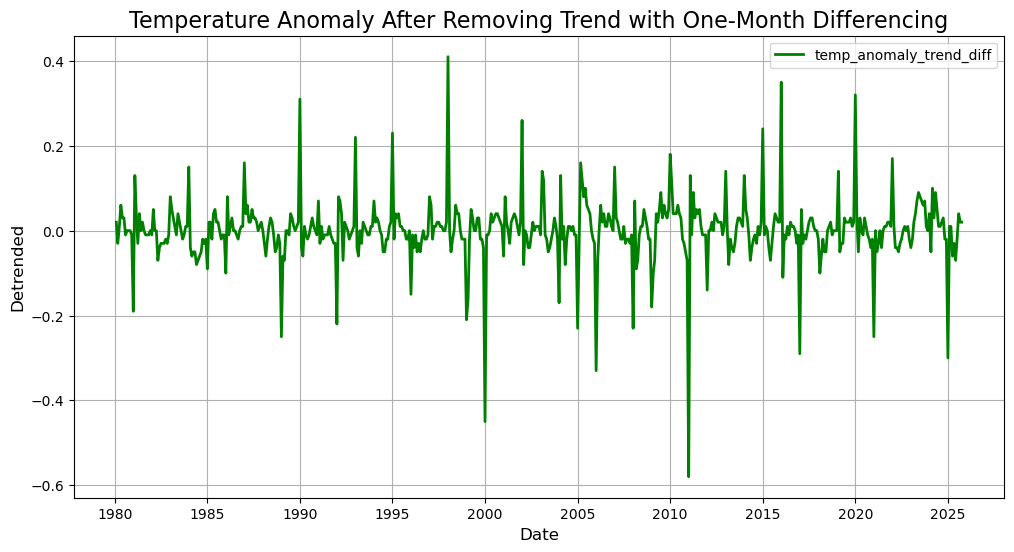

In [7]:
#Regular Differencing for trend removal
df_t['temp_anomaly_trend_diff'] = df['temp_anomaly'].diff().dropna()

result_diff = adfuller(df_t['temp_anomaly_trend_diff'].dropna())
print("ADF Statistic after Differencing:", result_diff[0].round(4))
print("p-value after Differencing:", result_diff[1].round(4))


#The plot after removing trend to check stationarity
plt.figure(figsize=(12, 6))
plt.plot(df.index, df_t['temp_anomaly_trend_diff'], label='temp_anomaly_trend_diff', linewidth=2, color='green')
plt.title('Temperature Anomaly After Removing Trend with One-Month Differencing', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Detrended', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

ADF Statistic after Differencing: -5.5333
p-value after Seasonal Differencing: 0.0


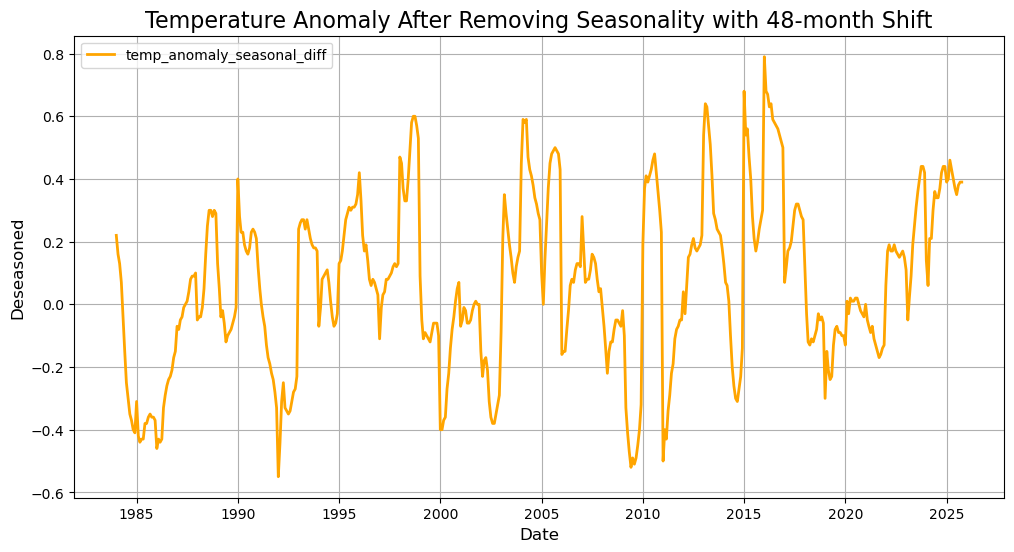

In [8]:
#Seasonal Differencing for Seasonality removal
df_t['temp_anomaly_seasonal_diff'] = df['temp_anomaly'] - df['temp_anomaly'].shift(48) #t-48 

result_diff_seasonal = adfuller(df_t['temp_anomaly_seasonal_diff'].dropna())
print("ADF Statistic after Differencing:", result_diff_seasonal[0].round(4))
print("p-value after Seasonal Differencing:", result_diff_seasonal[1].round(4))

plt.figure(figsize=(12, 6))
plt.plot(df.index, df_t['temp_anomaly_seasonal_diff'], label='temp_anomaly_seasonal_diff', linewidth=2, color='orange')
plt.title('Temperature Anomaly After Removing Seasonality with 48-month Shift', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Deseasoned', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

For *SARIMA* model, the following parameters were chosedn based on the analysis above:

- d = 1, regular difference for trend removal
- D = 1, seasonal difference for deseasoning
- m=48, 48 month seasonality

The selection of the remaining parameters of SARIMA:

Based on the ACF plot, significant spikes at lag 1 and 2 suggest an autoregressive relationship (AR), so *p* = 1 (non-seasonal AR term) can be a good choice. The ACF plot shows significant early lags, indicating the presence of short-term correlation in the errors. Therefore, q=1 (Non-Seasonal MA Term) is selected. From the seasonal lags in the PACF plot (e.g., lag 7, lag 14), P=1 (Seasonal AR Term) is chosen to account for seasonal dependencies. From the seasonal lags in the ACF plot, significant correlations are observed at seasonal lags, suggesting Q = 1 (Seasonal MA Term) to model the seasonal error dependencies.

To ensure the model’s performance and refine the parameter selection, a grid search can be applied. The model is evaluated using the Akaike Information Criterion (AIC), where a lower AIC value indicates a better model fit with reduced complexity. This systematic approach helps identify the optimal parameter combination for SARIMA.

## The SARIMA Model

This step involves fitting the SARIMA model to the data and evaluating its performance.

In [9]:
# Parameters
p, d, q = 1, 1, 1  # Non-seasonal ARIMA parameters
P, D, Q, m = 1, 1, 1, 48  # Seasonal parameters with weekly seasonality (m=7)

train = df_t[:-12] 
test = df_t[-12:]

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train['temp_anomaly'],
    order=(0, 1, 0),              #Non-seasonal parameters
    seasonal_order=(0, 1, 0, 48),  #Seasonal parameters (48 mo seasonality)
    enforce_stationarity=False,   #False since differencing (d and D) already handles non-stationarity
    enforce_invertibility=False   #Allow temporarily violate invertibility during optimization
)

sarima_fit = model.fit(disp=False)
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       temp_anomaly   No. Observations:                  538
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 48)   Log Likelihood                 419.629
Date:                            Mon, 08 Dec 2025   AIC                           -837.258
Time:                                    01:13:11   BIC                           -833.068
Sample:                                01-01-1980   HQIC                          -835.612
                                     - 10-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0105      0.000     51.406      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                  12.80   Jarque-Bera (JB):              7867.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

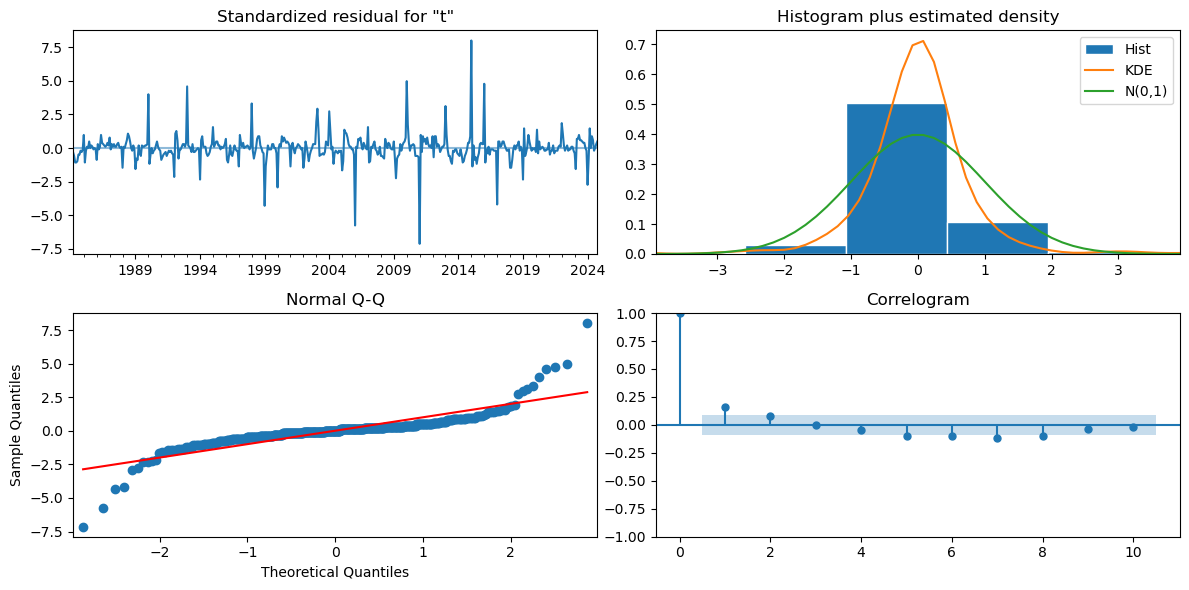

In [10]:
sarima_fit.plot_diagnostics(figsize=(12,6))
plt.tight_layout()

### Forecasting

In this section we will perform temperature anomaly forecsting using the previously built SARIMAX(0, 1, 0)x(0, 1, 0, 48) model. We divide the dataset into training (all but the last year) and testing set (last year until Oct 2025). The model is trained on the training set, and its performance is validated on the test set using evaluation metrics such as RMSE (Root Mean Square Error) and MAE (Mean Absolute Error). Finally, we use the model to forecast the next 12 months to show its predictive capability.

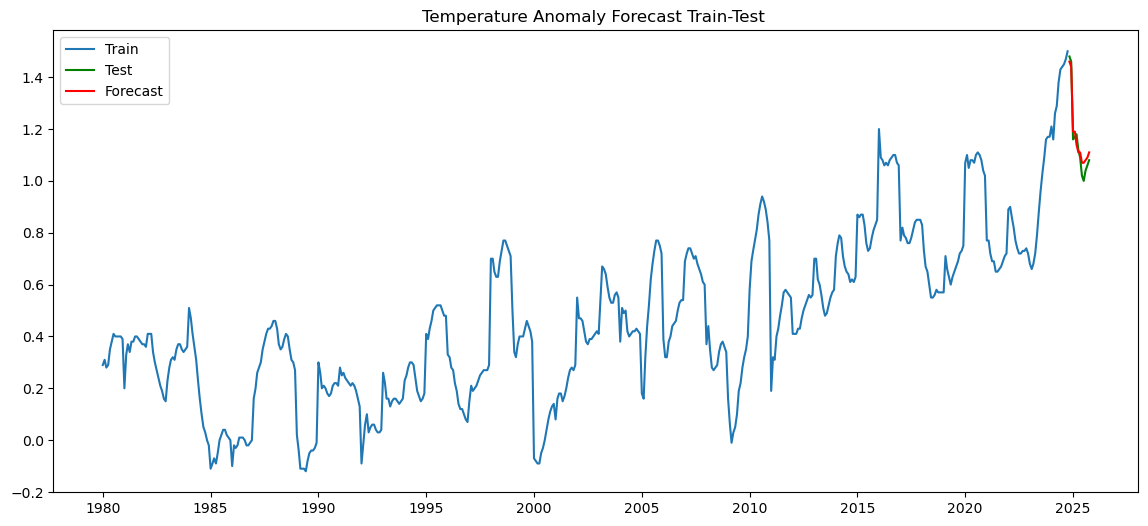

In [18]:
forecast_test = sarima_fit.forecast(steps=12)
forecast_test.index = test.index

plt.figure(figsize=(14, 6))
plt.plot(train['temp_anomaly'], label='Train')
plt.plot(test['temp_anomaly'], label='Test', color='green')
plt.plot(forecast_test, label='Forecast', color='red')
plt.title('Temperature Anomaly Forecast Train-Test ')
plt.legend()
plt.show()

### Forecast Evaluation

The forecasted results (red line) aligns quite well with the test data (green line). The Sarimax model was trained using 12, 24 and 48 months seasonality feature, 48-mo feature was the most efficient with AIC = 833.

Evaluation Statistics of the SARIMAX Model with parameters ARIMA(0,1,0)(0,1,0)[48]

- Mean Absolute Error = 0.03166666685170164
- Mean Squared Error =  0.0012500000185034974
- Root Mean Squared Error (RMSE) = 0.035355339321006346
- The r2_score  = 0.9454743721481571

On average, the model performed well enough with MAE=0.031, meaning that the model's predictions are approaximately 0.03 Celsius away from the true values. 
r2 score of 0.92 means that our model's explained 92% of data. 
RMSE of 0.035 means that model's predictions have an error of 0.035 Celsius.


In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

true_values = test['temp_anomaly']
predicted_values = forecast_test

print(f'Evaluation Statistics of the SARIMAX Model with parameters ARIMA(0,1,0)(0,1,0)[48]')

mae = mean_absolute_error(true_values, predicted_values)
print(f'Mean Absolute Error = {mae}')

mse = mean_squared_error(true_values, predicted_values)
print(f'Mean Squared Error =  {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) = {rmse}')

score = r2_score(true_values, predicted_values)
print(f'The r2_score  = {score}')

Evaluation Statistics of the SARIMAX Model with parameters ARIMA(0,1,0)(0,1,0)[48]
Mean Absolute Error = 0.03166666685170164
Mean Squared Error =  0.0012500000185034974
Root Mean Squared Error (RMSE) = 0.035355339321006346
The r2_score  = 0.9454743721481571


### Real Forecast (for 12 months)

In [20]:
# Train on the whole dataset for forecasting

model = SARIMAX(
    df_t['temp_anomaly'],
    order=(0, 1, 0),              #Non-seasonal parameters
    seasonal_order=(0, 1, 0, 48),  #Seasonal parameters (48 mo seasonality)
    enforce_stationarity=False,   #False since differencing (d and D) already handles non-stationarity
    enforce_invertibility=False   #Allow temporarily violate invertibility during optimization
)

sarima_fit = model.fit(disp=False)
sarima_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       temp_anomaly   No. Observations:                  550
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 48)   Log Likelihood                 435.499
Date:                            Mon, 08 Dec 2025   AIC                           -868.998
Time:                                    12:47:15   BIC                           -864.783
Sample:                                01-01-1980   HQIC                          -867.344
                                     - 10-01-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0103      0.000     52.587      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                  13.10   Jarque-Bera (JB):              8443.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
from dateutil.relativedelta import relativedelta

forecast_steps = 12
forecast = sarima_fit.forecast(steps=forecast_steps)
#Creating a date range for the forecast
future_dates = pd.date_range(start=df.index[-1] + relativedelta(months=1),periods=forecast_steps,freq='MS')

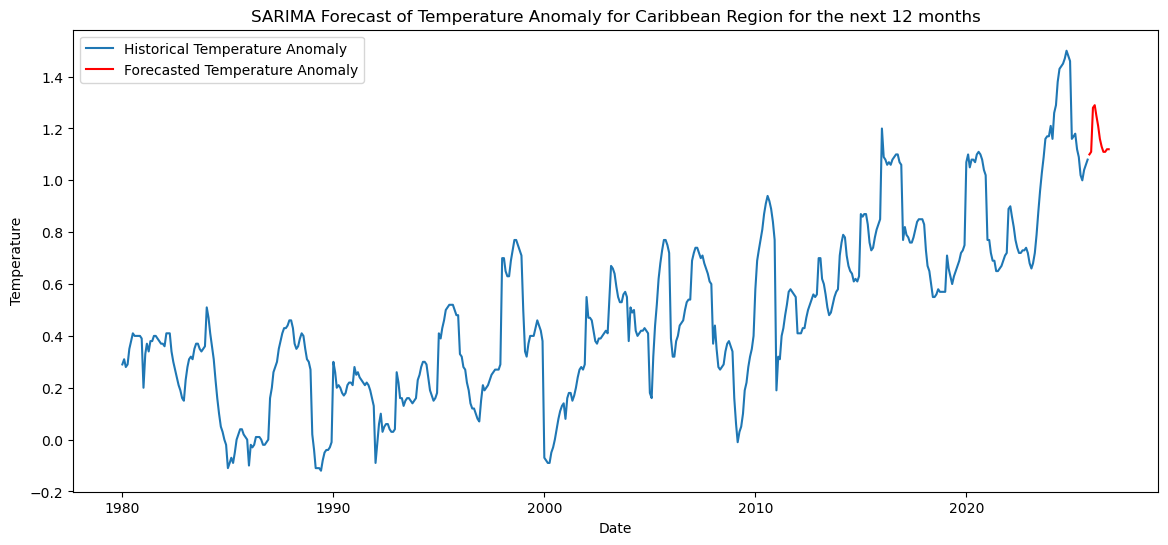

In [24]:

#Creating a forecast series
forecast_series = pd.Series(forecast, index=future_dates)

plt.figure(figsize=(14, 6))
plt.plot(df_t['temp_anomaly'], label='Historical Temperature Anomaly')
plt.plot(forecast_series, label='Forecasted Temperature Anomaly', color='red')
plt.title('SARIMA Forecast of Temperature Anomaly for Caribbean Region for the next 12 months')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Forecast Notes

Our prediction for the next year for the Caribbean Region, as shown in the plot in red, serves as baseline supportive tool for forecasting temperatures and making informative decisions based on expected trends and patterns.